In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

#import pynwb
import h5py

from sklearn.decomposition import PCA

# Step 0: download and unzip the data

As of June 2025, the data live here:
http://fileshare.lisc.univie.ac.at/zimmer_freely_moving_traces/nwb.zip 

In the future they will be hosted on DANDI

# Step 1: reading NWB files

### Not suggested: eager loading using pynwb

Depending on the size of the file, this can take a very long time

However, it is the official pynwb library, so hopefully future versions will improve this

In [ ]:
#nwbfile_eager = pynwb.read_nwb(os.path.join(path, 'ZIM2165_Gcamp7b_worm1-2022_11_28_no_image_data.nwb')

### Suggested: lazy loading using hdf5

This uses the lower level hdf5 library, and highlights a key point: .nwb files are actually just .h5 files

In [ ]:
path = f'{os.getcwd()}/../data/{os.path.basename(os.getcwd())}/exported_data_gcamp/'					# path to nbw file folder
hdf5file = h5py.File(os.path.join(path, 'ZIM2165_Gcamp7b_worm1-2022_11_28_no_image_data.nwb'), 'r')		# load some file


# Step 1b: examining the object

This is purely exploratory; for subsequent analysis feel free to skip!

### Printing file structure using `visititems`

In [4]:
def print_structure(name, _):
	print(name)

hdf5file.visititems(print_structure)

acquisition
analysis
file_create_date
general
general/devices
general/devices/Spinning disk confocal
general/institution
general/lab
general/optophysiology
general/optophysiology/CalciumImVol
general/optophysiology/CalciumImVol/GFP-GCaMP
general/optophysiology/CalciumImVol/GFP-GCaMP/description
general/optophysiology/CalciumImVol/GFP-GCaMP/emission_lambda
general/optophysiology/CalciumImVol/GFP-GCaMP/emission_range
general/optophysiology/CalciumImVol/GFP-GCaMP/excitation_lambda
general/optophysiology/CalciumImVol/GFP-GCaMP/excitation_range
general/optophysiology/CalciumImVol/description
general/optophysiology/CalciumImVol/excitation_lambda
general/optophysiology/CalciumImVol/grid_spacing
general/optophysiology/CalciumImVol/indicator
general/optophysiology/CalciumImVol/location
general/optophysiology/CalciumImVol/mScarlet
general/optophysiology/CalciumImVol/mScarlet/description
general/optophysiology/CalciumImVol/mScarlet/emission_lambda
general/optophysiology/CalciumImVol/mScarlet/emis

### Accessing specific fields via dict indexing

In [ ]:
hdf5file['processing'].visititems(print_structure)

Behavior
Behavior/continuous_behaviors
Behavior/continuous_behaviors/angular_velocity
Behavior/continuous_behaviors/angular_velocity/data
Behavior/continuous_behaviors/angular_velocity/timestamps
Behavior/continuous_behaviors/body_curvature
Behavior/continuous_behaviors/body_curvature/data
Behavior/continuous_behaviors/body_curvature/timestamps
Behavior/continuous_behaviors/dorsal_only_body_curvature
Behavior/continuous_behaviors/dorsal_only_body_curvature/data
Behavior/continuous_behaviors/dorsal_only_body_curvature/timestamps
Behavior/continuous_behaviors/dorsal_only_head_curvature
Behavior/continuous_behaviors/dorsal_only_head_curvature/data
Behavior/continuous_behaviors/dorsal_only_head_curvature/timestamps
Behavior/continuous_behaviors/head_curvature
Behavior/continuous_behaviors/head_curvature/data
Behavior/continuous_behaviors/head_curvature/timestamps
Behavior/continuous_behaviors/reversal_events
Behavior/continuous_behaviors/reversal_events/data
Behavior/continuous_behaviors/r

### Accessing subfields using `/`

In [6]:
hdf5file['processing/Behavior/continuous_behaviors'].visititems(print_structure)

angular_velocity
angular_velocity/data
angular_velocity/timestamps
body_curvature
body_curvature/data
body_curvature/timestamps
dorsal_only_body_curvature
dorsal_only_body_curvature/data
dorsal_only_body_curvature/timestamps
dorsal_only_head_curvature
dorsal_only_head_curvature/data
dorsal_only_head_curvature/timestamps
head_curvature
head_curvature/data
head_curvature/timestamps
reversal_events
reversal_events/data
reversal_events/timestamps
velocity
velocity/data
velocity/timestamps
ventral_only_body_curvature
ventral_only_body_curvature/data
ventral_only_body_curvature/timestamps
ventral_only_head_curvature
ventral_only_head_curvature/data
ventral_only_head_curvature/timestamps


### Lazy loading field as hdf5 dataset

In [7]:
velocity_hdf5 = hdf5file['processing/Behavior/continuous_behaviors/velocity/data']
velocity_hdf5

<HDF5 dataset "data": shape (1667,), type "<f8">

### In-memory reading as numpy array using `[:]`

In [8]:
velocity = velocity_hdf5[:]
velocity

array([ 0.09178562,  0.09417407,  0.10170426, ..., -0.04149632,
        0.05574242,  0.06426989], shape=(1667,))

# Step 2: example plots

### Helper functions to read some data into dataframes and catch missing fields

In [9]:
def get_filename(file_handle):
	return file_handle.filename.split('/')[-1].split('.')[0]

def get_continuous_behaviors(file_handle):
	try:
		data = pd.DataFrame({key: file_handle[f'/processing/Behavior/continuous_behaviors/{key}/data'][:] for key in file_handle[f'/processing/Behavior/continuous_behaviors'].keys()})
	except KeyError:
		print(f'No continuous behavior data for {os.path.basename(file_handle.filename)}')
		data = None
	return data

def get_discrete_states(file_handle):
	try:
		data = pd.DataFrame({key: file_handle[f'/processing/Behavior/discrete_states/{key}/data'][:] for key in file_handle[f'/processing/Behavior/discrete_states'].keys()})
	except KeyError:
		print(f'No discrete state data for {os.path.basename(file_handle.filename)}')
		data = None
	return data

def get_eigenworms(file_handle):
	try:
		data = pd.DataFrame({key: file_handle[f'/processing/Behavior/eigenworms/{key}/data'][:] for key in file_handle[f'/processing/Behavior/eigenworms'].keys()})
	except KeyError:
		print(f'No eigenworm data for {os.path.basename(file_handle.filename)}')
		data = None
	return data

def get_kymograph(file_handle):
	try:
		data = pd.DataFrame({key: file_handle[f'/processing/Behavior/kymograph/{key}/data'][:] for key in file_handle[f'/processing/Behavior/kymograph'].keys()})
	except KeyError:
		print(f'No kymograph data for {os.path.basename(file_handle.filename)}')
		data = None
	return data

def get_neuronal_traces(file_handle):
	try:
		data = pd.DataFrame(file_handle[f'/processing/CalciumActivity/SignalDFoF/SignalCalciumImResponseSeries/data'][:],
							 columns=[n_id.decode('utf-8') for n_id in file_handle[f'/processing/CalciumActivity/NeuronIDs/labels'][:]])
	except KeyError:
		print(f'No neuronal trace data for {os.path.basename(file_handle.filename)}')
		data = None
	return data

In [10]:
filename = get_filename(hdf5file)
continuous_behaviors = get_continuous_behaviors(hdf5file)
discrete_states = get_discrete_states(hdf5file)
eigenworms = get_eigenworms(hdf5file)
kymograph = get_kymograph(hdf5file)
neuronal_traces = get_neuronal_traces(hdf5file)

print('continuous behaviors\n', list(continuous_behaviors.columns), '\n')
print('discrete states\n', list(discrete_states.columns), '\n')
print('eigenworms\n', list(eigenworms.columns), '\n')
print('kymograph\n', list(kymograph.columns), '\n')
print('neuronal traces\n', list(neuronal_traces.columns), '\n')

continuous behaviors
 ['angular_velocity', 'body_curvature', 'dorsal_only_body_curvature', 'dorsal_only_head_curvature', 'head_curvature', 'reversal_events', 'velocity', 'ventral_only_body_curvature', 'ventral_only_head_curvature'] 

discrete states
 ['DORSAL_TURN', 'FWD', 'PAUSE', 'REV', 'SLOWING', 'TRACKING_FAILURE', 'UNKNOWN', 'VENTRAL_TURN'] 

eigenworms
 ['0', '1', '2', '3', '4'] 

kymograph
 ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'] 

neuronal tr

### Behavioral annotations

[[ 1.         -0.91066991]
 [-0.91066991  1.        ]]


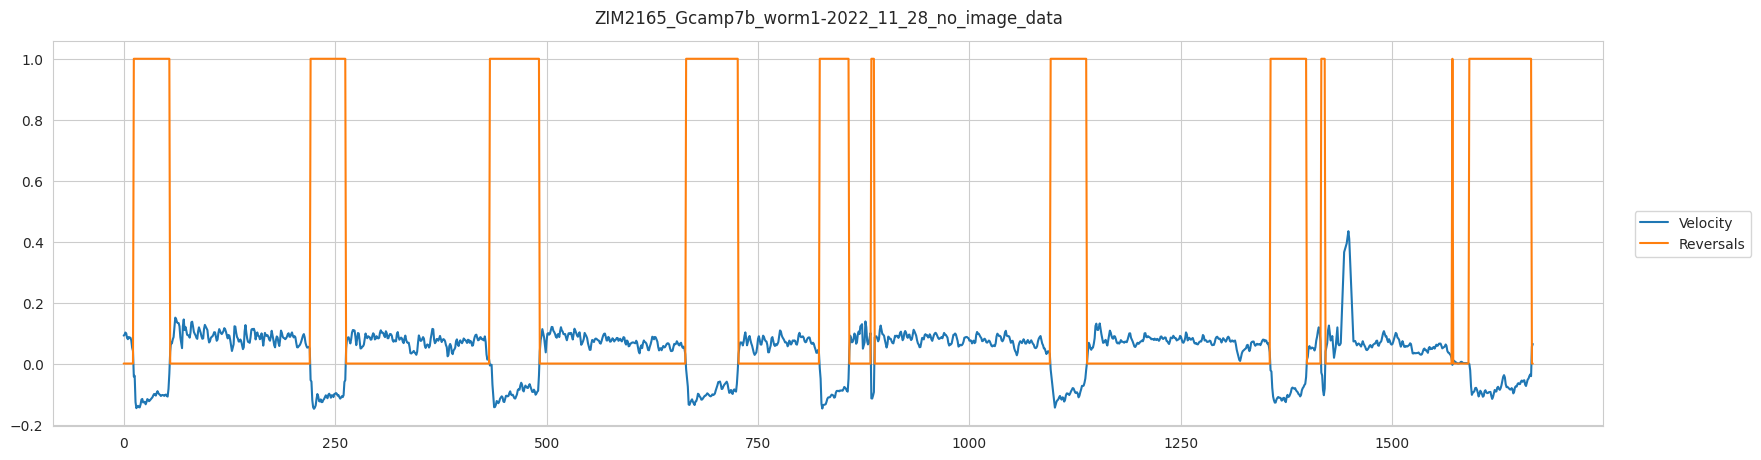

In [11]:
velocity = continuous_behaviors['velocity']
reversals = discrete_states['REV']

x = np.arange(len(velocity))  # one can access /processing/Behavior/continuous_behaviors/velocity/timestamps for the proper sampling rate

plt.figure(figsize=(20, 5))
plt.plot(x, velocity, label='Velocity')
plt.plot(x, reversals, label='Reversals')
plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
plt.title(f'{filename}', y=1.025, fontsize=12)

corr = np.corrcoef(velocity, reversals)
print(corr)

### Neuronal traces

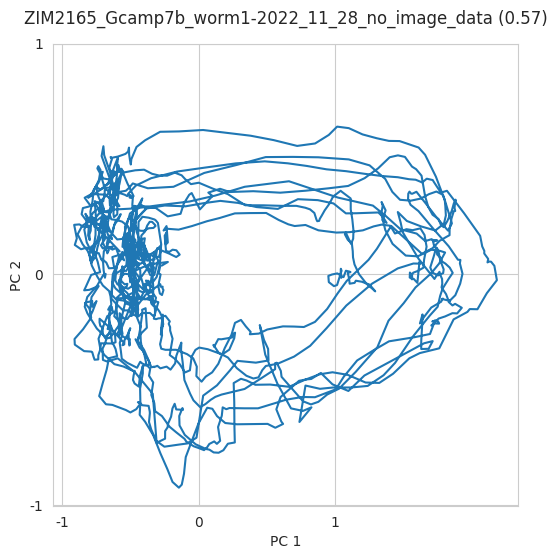

In [12]:
signal = neuronal_traces.values
pca = PCA(n_components=2)
signal_reduced = pca.fit_transform(signal)

plt.figure(figsize=(6, 6))
plt.plot(signal_reduced[:, 0], signal_reduced[:, 1])
plt.xticks(np.arange(-1, 2, 1), np.arange(-1, 2, 1))
plt.yticks(np.arange(-1, 2, 1), np.arange(-1, 2, 1))
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title(f'{filename} ({sum(pca.explained_variance_ratio_):.2f})', y=1.025, fontsize=12)
plt.show()

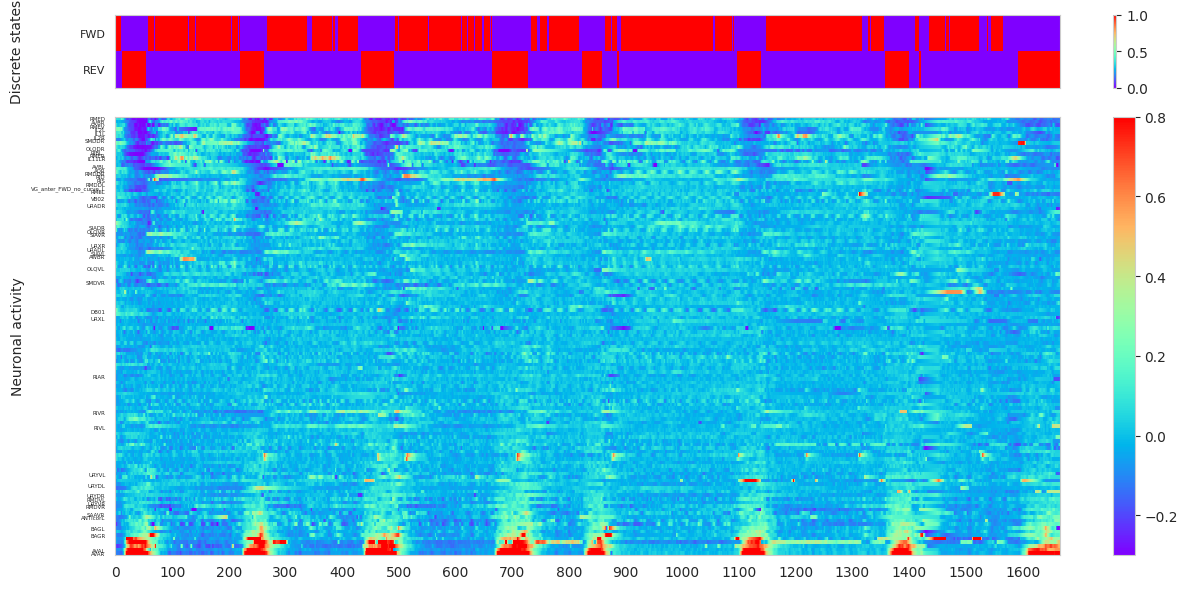

In [13]:
fig, (ax_top, ax_bottom) = plt.subplots(2, 1, figsize=(12, 6), sharex=True, gridspec_kw={'height_ratios': [1, 6]})

selections = ['FWD', 'REV']

im_top = ax_top.imshow(discrete_states[selections].values.T, aspect='auto', cmap='rainbow', interpolation='nearest')
ax_top.grid(False)
ax_top.set_xticks(np.arange(0, len(discrete_states[selections].values), 100))
ax_top.set_yticks(np.arange(len(discrete_states[selections].columns)))
ax_top.set_yticklabels(discrete_states[selections].columns, fontsize=8)
ax_top.set_ylabel('Discrete states', labelpad=40)
fig.colorbar(im_top, ax=ax_top, orientation='vertical', fraction=0.05)

sorting_indices = np.argsort(pca.components_[0])

im_bottom = ax_bottom.imshow(np.clip(signal.T[sorting_indices], -0.3, 0.8), aspect='auto', cmap='rainbow', interpolation='nearest')
ax_bottom.grid(False)
ax_bottom.set_xticks(np.arange(0, len(signal), 100))
ax_bottom.set_yticks(np.arange(len(neuronal_traces.columns)))
ax_bottom.set_yticklabels(neuronal_traces.columns[sorting_indices], fontsize=4)
ax_bottom.set_ylabel('Neuronal activity')
fig.colorbar(im_bottom, ax=ax_bottom, orientation='vertical', fraction=0.05)

plt.tight_layout()
plt.show()

### Kymograph

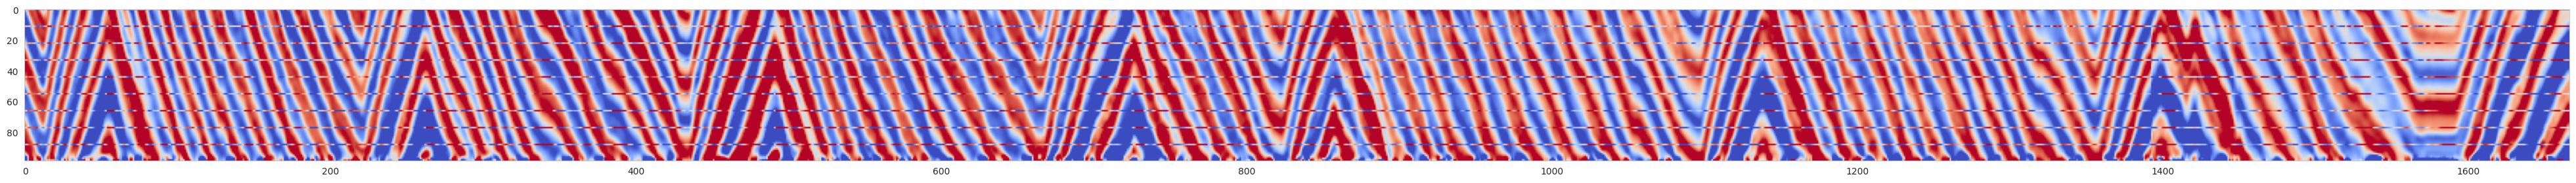

In [23]:
plt.figure(figsize=(50, 800))
plt.grid(False)

plt.imshow(np.clip(kymograph, -0.01, 0.01).T, cmap='coolwarm')
plt.show()

### Neuronal correlation clustermap

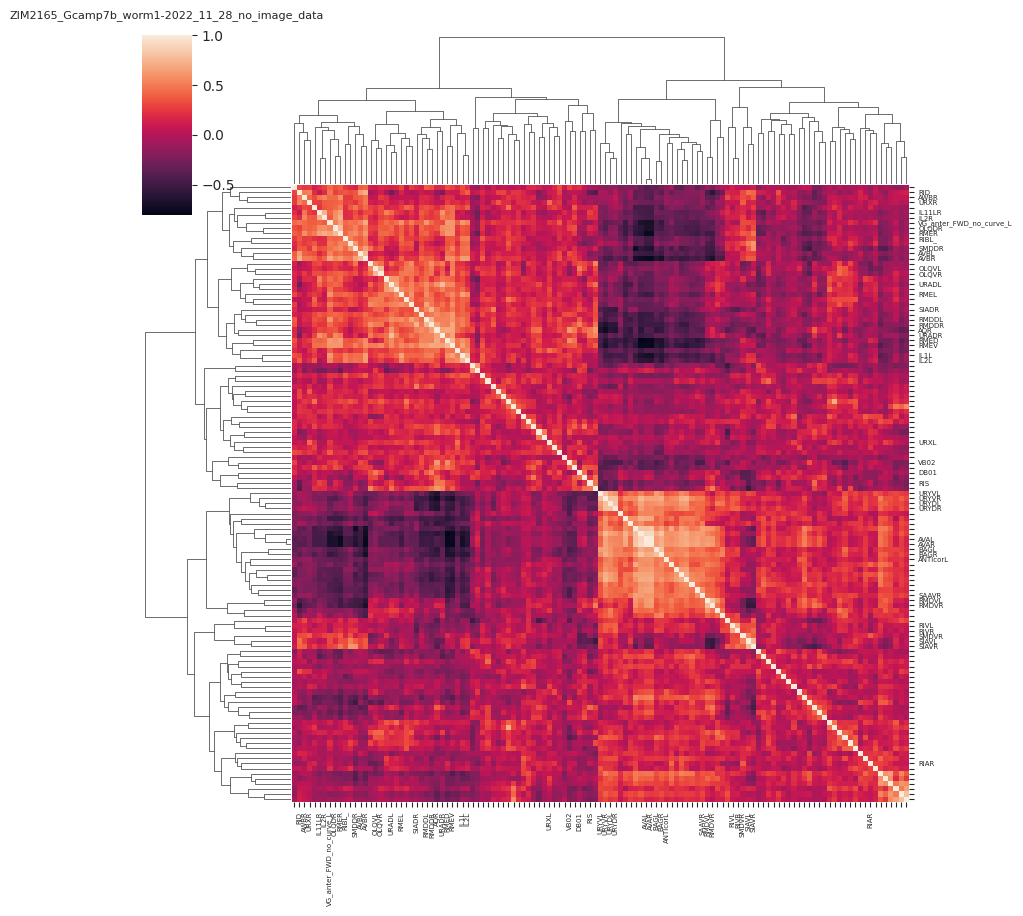

In [15]:
correlation = neuronal_traces.corr()
heatmap = sns.clustermap(correlation, yticklabels=True, xticklabels=True)
heatmap.ax_heatmap.set_yticklabels(heatmap.ax_heatmap.get_yticklabels(), fontsize=5)
heatmap.ax_heatmap.set_xticklabels(heatmap.ax_heatmap.get_xticklabels(), fontsize=5)
heatmap.ax_heatmap.tick_params(axis='x', bottom=True, top=False)

plt.title(f'{filename}', y=1.05, fontsize=8)
plt.show()

### Behavioral correlation clustermap

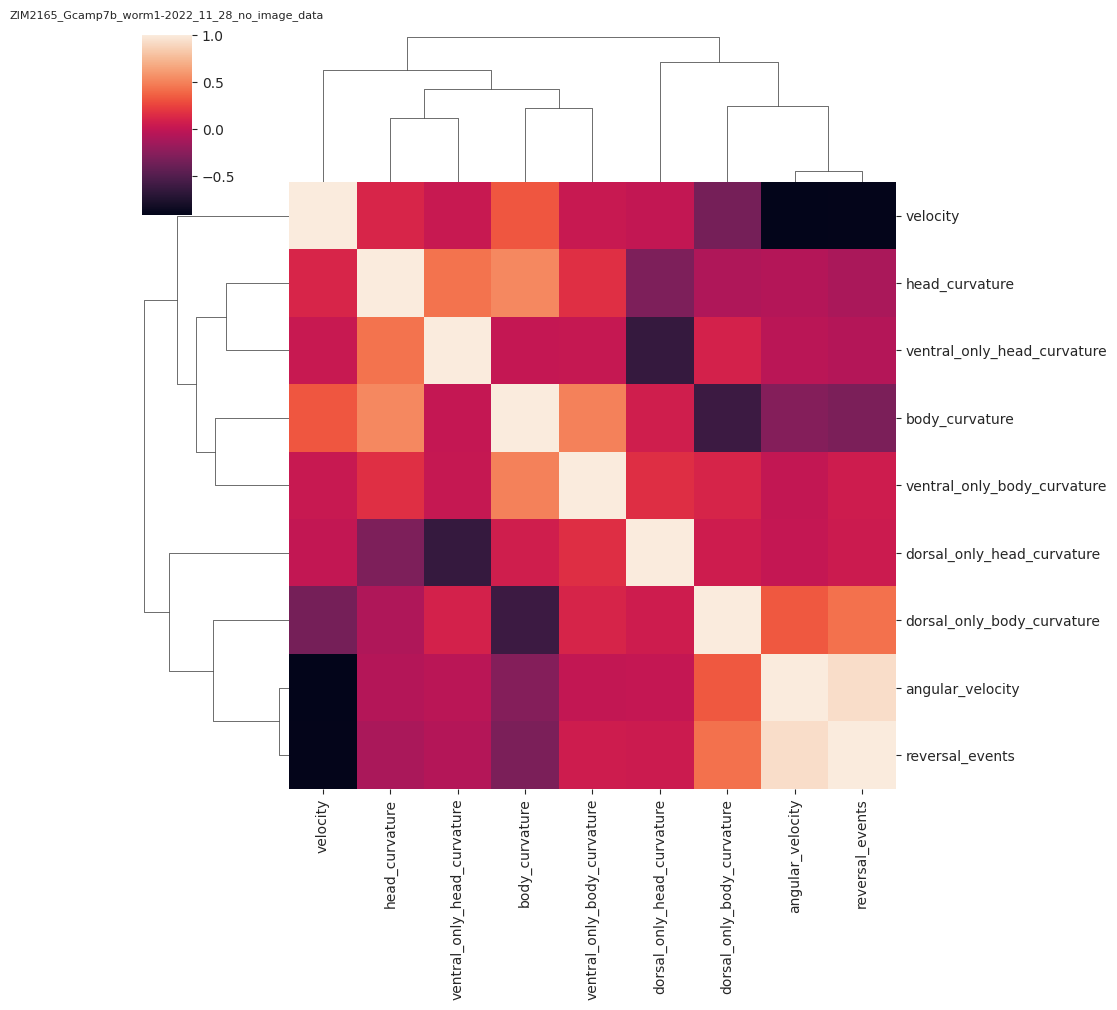

In [16]:
correlation = continuous_behaviors.corr()
heatmap = sns.clustermap(correlation, yticklabels=True, xticklabels=True)
heatmap.ax_heatmap.set_yticklabels(heatmap.ax_heatmap.get_yticklabels(), fontsize=10)
heatmap.ax_heatmap.set_xticklabels(heatmap.ax_heatmap.get_xticklabels(), fontsize=10)
heatmap.ax_heatmap.tick_params(axis='x', bottom=True, top=False)

plt.title(f'{filename}', y=1.05, fontsize=8)
plt.show()